# **Assignment \#3**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2



In [1]:
# TODO: RA & Name 
print('RA1:139373 ' + 'Cinthia Cristina Calchi Kleiner')
print('RA2:103897 ' + 'Randerson A Lemos')

RA1:139373 Cinthia Cristina Calchi Kleiner
RA2:103897 Randerson A Lemos


## Objective 

Explore **neural networks** and develop the best possible model for the problem, avoiding overfitting. In particular, build an object recognition system to classify images using the [BloodMNIST dataset](https://doi.org/10.1016/j.dib.2020.105474) accurately. 

In this activity, **you are not allowed to use neural networks frameworks** (e.g., Pytorch, Tensorflow, Keras), except basic functions such as Dataloaders which are already specified in the code cells. You should implement the required methods using [NumPy](https://numpy.org/doc/1.23/user/index.html#user). Also, you can use ``scikit-learn`` (or similar libraries) to compute evaluation metrics, and all the plotting libraries are allowed too. 

We created a sanity check for all the methods you have to implement, so you can check whether the overall behavior of your algorithm is correct. However, it does not guarantee that your implementation is correct, unfortunately debugging neural networks models is a hard task.

## Dataset

BloodMNIST is one of the image datasets of [MedMNIST](https://medmnist.com/). It is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. It is split into a training set of 11,959 examples, a validation set of 1,712 examples, and a test set of 3,421 examples. Each example is a 3x28x28 RGB image, associated with a label from 8 classes.

Each example is assigned to one of the following labels:

|Class ID| Cell Type | #Images | % |
|--------|-----------|---------|---|
|   0    | basophils | 1218 | 7.13 |
|   1    | eosinophils | 3117 | 18.24 |
|   2    | erythroblasts | 1551 | 9.07 |
|   3    | immature granulocytes | 2895 | 16.94 |
|   4    | lymphocytes | 1214 | 7.10 |
|   5    | monocytes | 1420 | 8.31 |
|   6    | neutrophils | 3329 | 19.48 |
|   7    | platelets (thrombocytes) | 2348 |13.74 |


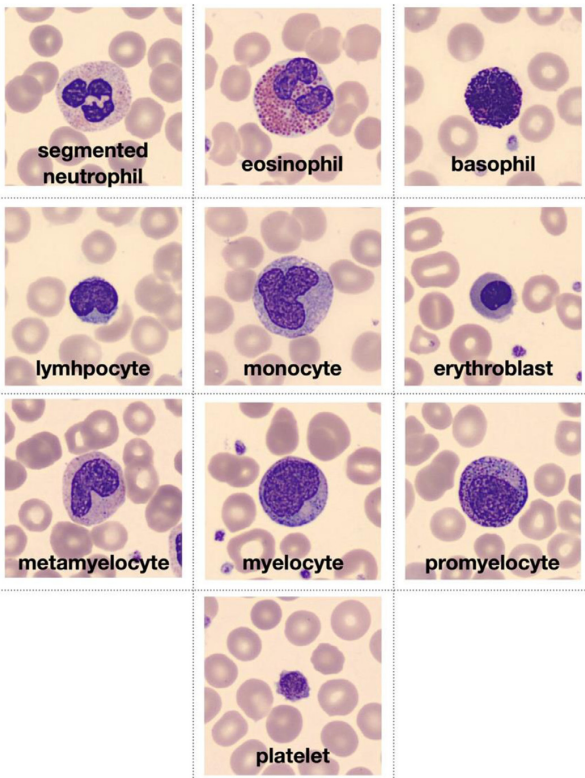

**Dataset Information:**

- You should respect the following training/validation/test split. Avoid overfitting.
- The data is available at Google Classroom or at https://drive.google.com/file/d/1DPGlDIRp_kGqhHyUAlkL7OH8RVbkRRbi/view?usp=sharing
- You should evaluate the models using **balanced accuracy** or **AUC**.

## Deadline
Friday, October 21 11:59pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- October 22 11:59pm : grade * 0.75
- October 23 11:59pm : grade * 0.5
- October 24 11:59pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-people group).**

In [2]:
from typing import List
from abc import ABC,abstractmethod
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import balanced_accuracy_score as sklearn_acc, roc_auc_score

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import time
import torch
import pickle
import pandas as pd

Setting a seed in torch and numpy:

In [3]:
SEED = 7
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
def balanced_accuracy_score(Y, Y_pred):
    '''
    Wrapper function to use sklearn balanced accuracy score
    Args:
        Y: ground truth
        Y_pred: predictions
    Returns:
        sklearn balanced accuracy score
    '''
    Y = np.argmax(Y, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)
    return sklearn_acc(Y, Y_pred)

In [5]:
# prepare data to use with Pytorch Dataloader

class BloodMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):                  
        image = self._x[idx]
        if self._transform is not None:        
            image = self._transform(image)
        
        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * 8
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [6]:
# an example of normalization function, but you can implement others
def normalize(X):
#     return X/255
    return (X - X.mean())/(X.std() + 1e-8)

#### Loading data

In [7]:
# set the dataset path correctly 
dataset_path = 'bloodmnist.npz'
bloodmnist = np.load(dataset_path)

x_train, y_train = bloodmnist['train_images'], bloodmnist['train_labels']
x_val, y_val = bloodmnist['val_images'], bloodmnist['val_labels']

# you do not have access to the labels of the test set
x_test = bloodmnist['test_images']

In [8]:
train_set = BloodMNIST(x_train, y_train, transform=normalize)
val_set = BloodMNIST(x_val, y_val, transform=normalize)
test_set = BloodMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## Implementation tasks

#### Activation & Loss Functions

Activation functions are essential components of a neural network. So, explore different activation functions in your models and analyze the differences in the results. Also, implement the cross-entropy and use it as your loss function since you are working on a multi-class classification problem.

Implement, in the indicated place, the following functions:

* Softmax (its gradient is already implemented);
* Cross-Entropy (its gradient is already implemented);
* An activation function of your preference, as well as its gradient. It must be a subclass of ``BaseFunction``. (For reference, read this [blog post](https://dwaithe.github.io/blog_20170508.html).)

In [9]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass
        
    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):    
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

########################################################
# TODO: implement here another activation function
########################################################

class LeakyRelu(BaseFunction):    
        
    def __call__(self, X, alpha=0.01):
        return np.maximum(alpha * X, X)
        
    def grad(self, X, alpha=0.01):
        return np.where(X>=0, 1, alpha)
        

class Softmax(BaseFunction):    
    def __call__(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Softmax output
        """    
        ##################################
        # TODO: implement here the Softmax
        ##################################
        max_ = np.max(X, axis=1, keepdims=True)
        exp = np.exp(X - max_)
        sum_ = np.sum(exp, axis=1, keepdims=True)
        return exp / sum_ 
        
    def grad(self, X):
        return 1 # discard this gradient


class CrossEntropy(BaseFunction):    
    def __call__(self, Y, Y_pred):
        """
        Arguments:
        Y: (np.array) ground-truth labels
        Y_pred: (np.array) predicted labels

        Return:
        Cross-Entropy output
        """ 
        ##################################
        # TODO: implement here the Cross-Entropy
        ##################################
        epsilon = 1e-8
        pred = np.clip(Y_pred, epsilon, 1. - epsilon)
        cross_entropy = -np.sum(Y * np.log(pred+epsilon)) / pred.shape[0]
        return cross_entropy

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradient with respect to Softmax's input

**Sanity Check**

In [10]:
######## checking Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [11]:
######## checking CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])


expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred) 
assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

#### Model

In a neural network, the predictions are made using an algorithm called Feedforward, also known as the forward step. Thus, you have to implement this method to make predictions using your models. 

In addition, it is critical to initialize the network weights properly to ensure a better-performing model. Otherwise, it can give rise to a Vanishing Gradient or Exploding Gradient problem. So, try different weights initialization techniques and see what happens. We already implemented the random and [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) Normal initialization for you :D

Implement, in the indicated place, the following methods:

* Feedforward, also known as the forward step;
* A weight initialization method of your choice. (For reference, read this [blog post](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).)

PS. Note that the weight matrices $W$ in the network are constructed so that $w^{l}_{i,j}$ is the weight that connects the i-th neuron in the l-th layer to the j-th neuron in the following layer, as illustrated below.



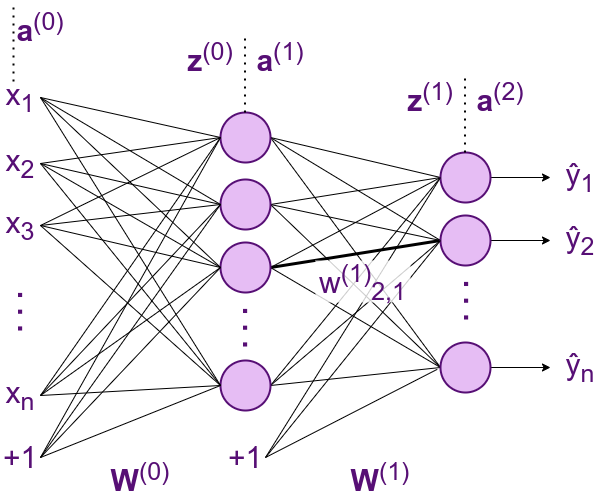


**Feed Forward**:

$a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [12]:
class Model:
    def __init__(self, layers_dims: List[int], 
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions 
        initialization_method: (str) indicates how to initialize the parameters

        Example:
        
        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"
        
        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)
        
    def save(self, filepath):
        with open(filepath, "wb") as f:
            pickle.dump({
                "weights": self.weights,
                "bias": self.bias,
                "activation_funcs": self.activation_funcs,
                "layer_dims": self.layers_dims,
            }, f)
         
    @classmethod
    def from_pretrained_weights(cls, filepath):
        # create a dummy model, we will overwrite its attributes later
        model = cls([1], [])
        # load model
        with open(filepath, "rb") as f:
            saved_model = pickle.load(f)
        model.weights = saved_model["weights"]
        model.bias = saved_model["bias"]
        model.activation_funcs = saved_model["activation_funcs"]
        model.layers_dims = saved_model["layer_dims"]
        return model


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of 
        matrices (np.array) of biases.
        """
        
        
        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        
        
        for l in range(0, n_layers-1):
            
            # the weight w_i,j  connects the i-th neuron in the current layer to
            # the j-th neuron in the next layer  
            
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])
            
            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])

            ###################################################
            # TODO: implement another initialization method
            #   ...
            ###################################################
            if method.lower() == 'xavier':
                # The Xavier inicialization is equals to he, but considers the n of inputs and outputs.
                #Whiles the He inicialization only considers the inputs
                W = W * np.sqrt(2/self.layers_dims[l+1] + 8)
                b = b * np.sqrt(2/self.layers_dims[l+1] + 8)
                
            if method.lower() == 'xavier':
                # The Xavier inicialization is equals to he, but considers the n of inputs and outputs.
                #Whiles the He inicialization only considers the inputs
                W = W * np.sqrt(2/self.layers_dims[l+1] + 8)
                b = b * np.sqrt(2/self.layers_dims[l+1] + 8)

            weights.append(W)
            bias.append(b)

        return weights, bias


    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """      
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implement here the forward step.
        #
        # A few more instructions:
        # Note that the weights, bias and activation functions are class variables,
        # then you can access them via ``self``.
        #
        # You should store the input Z of each activation function in ``Z_list``,
        # and the output of the activation functions in ``activations``. These
        # information will be important when you implement the backward pass.
        #############################################################################
        for weights, bias, activation_func in zip(self.weights, self.bias, self.activation_funcs):
            Z = np.dot(X, weights) + bias
            A = activation_func(Z)
            X = A
            self.Z_list.append(Z)
            self.activations.append(A)
        return X

**Sanity check**

In [13]:
######## checking Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0 ,1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),                
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,                        
                        np.array([[2],
                                  [0]]),                                            
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

#### Optimizers

Once you have designed your neural network's topology/architecture, it is time to train it. To do so, you need to select an optimizer (e.g., SGD, Momentum, Adagrad, Adam, RMSProp) that will update the network's weights. 

Implement in the indicated place:

* Stochastic Gradient Descent (SGD);
* Another optimizer of your preference. It must be a subclass of ``BaseOptimizer``. (For reference, read http://ruder.io/optimizing-gradient-descent.)

In [14]:
class BaseOptimizer(ABC):    
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        ###############################################################
        # TODO: implement Stochastic Gradient Descent (SGD) algorithm
        ###############################################################
        for i, (grad_w, grad_b) in enumerate(grads):
            self.model.weights[i] = self.model.weights[i] - self.lr * grad_w
            self.model.bias[i] = self.model.bias[i] - self.lr * grad_b
    
class RMSpropOptimizer(BaseOptimizer):
    def __init__(self,  model, beta=0.9, lr=1e-3):
        self.model = model
        self.beta = beta
        self.lr = lr
        self.mv_weights = [np.zeros(weights.shape) for weights in self.model.weights]
        self.mv_bias = [np.zeros(bias.shape) for bias in self.model.bias]
        
    def step(self, grads: List):
        for i, (grad_w, grad_b) in enumerate(grads):
            w = self.model.weights[i]
            b = self.model.bias[i]
            mv_w = self.mv_weights[i]
            mv_b = self.mv_bias[i]
      
            mv_w = self.beta*mv_w + (1-self.beta)*grad_w**2
            mv_b = self.beta*mv_b + (1-self.beta)*grad_b**2
            w = w - self.lr*grad_w/(np.sqrt(mv_w) + 1e-8)
            b = b - self.lr*grad_b/(np.sqrt(mv_b) + 1e-8)
            
            self.model.weights[i] = w
            self.model.bias[i] = b
            self.mv_weights[i] = mv_w
            self.mv_bias[i] = mv_b
            

**Sanity check**

The sanity check of SGD is placed after ``Trainer`` because it uses the backpropagation algorithm to compute the gradients.

#### Trainer

A weight $w_{i,j}$ of a neural network is updated based on the gradient of the loss function for $w_{i,j}$. Then, we need to compute the gradient of the loss function with respect to all the weights and biases in each layer in the network. This process is called backpropagation, a.k.a backward step. 

Implement:
* Backpropagation algorithm.

> *Hint: use the following recursive equations to compute the backpropagation.*
>
> $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial C}{\partial z^{(L-1)}}$
>
> $\frac{\partial C}{\partial z^{(l)}} = [\frac{\partial C}{\partial z^{(l+1)}} \cdot W_{(l+1)}^T] \odot \frac{\partial f_{(l)}}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial W^{(l)}} = \frac{1}{m} \cdot a^{(l)^T} \cdot \frac{\partial C}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial b^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial C}{\partial z_i^{(l)}}$
>
> Where $C$ is your cost/loss function, $m$ is the batch size,  $a^{(L)}$ is the last activation function output, $z_i^{(l)}$ is the i-th row of the matrix $z^{(l)}$, and $\odot$ is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))/element-wise product. 

In [15]:
class Trainer:
    def __init__(self, model: Model, optimizer, loss_func: CrossEntropy):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0

    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return: 
        A list of tuples of matrices (weights' gradient, biases' gradient) both in np.array format.
        The order of this list should be the same as the model's weights. 
        For example: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implement here the backward step.
        ############################################################
        
        m   = Y.shape[0]

        L    = len(self.model.activations) - 1
        WL   = None
        aL   = self.model.activations[L]
        aLm  = self.model.activations[L-1]
        zLm  = self.model.Z_list[L-1]
        gLm  = self.model.activation_funcs[L-1]
        dgLm = gLm.grad(zLm)

        delta = (aL - Y)*dgLm
        dw    = np.dot(aLm.T, delta) / m
        db    = np.sum(delta, axis=0) / m
        grads = [ (dw, db, ) ]

        while L > 1:
            L     = L - 1
            WL    = self.model.weights[L]
            aLm   = self.model.activations[L-1]
            zLm   = self.model.Z_list[L-1]
            gLm   = self.model.activation_funcs[L-1]
            dgLm  = gLm.grad(zLm)

            delta = np.dot(delta, WL.T)*dgLm
            dw    = np.dot(aLm.T, delta) / m
            db    = np.sum(delta, axis=0) / m
            grads.append( (dw, db, ) )
        return grads[::-1]
              
    
    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return: 
        A dictionary with the log of train and validation loss along the epochs
        """
        log_dict = {'epoch': [], 
                   'train_loss': [], 
                   'val_loss': [],
                   'train_acc':[],
                   'val_acc': [],
                   'train_auc':[],
                   'val_auc':[]}

        self.batch_size = train_loader.batch_size
        for epoch in tqdm(range(n_epochs)):
            train_loss_history = []
            train_gts = []
            train_preds = []
            for i, batch in enumerate(train_loader):                
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()                         
                Y_pred = self.model.forward(X)

                train_loss = self.loss_func(Y, Y_pred)
                train_gts.append(Y)
                train_preds.append(Y_pred)
                train_loss_history.append(train_loss)

                grads = self.backward(Y)
                self.optimizer.step(grads)

            val_loss_history = []
            val_gts = []
            val_preds = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)
                
                val_gts.append(Y)
                val_preds.append(Y_pred)         

            # appending losses to history
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()
            
            train_gts = np.concatenate(train_gts, axis=0)
            train_preds = np.concatenate(train_preds, axis=0)
            
            val_gts = np.concatenate(val_gts, axis=0)
            val_preds = np.concatenate(val_preds, axis=0)
            
            train_acc = balanced_accuracy_score(train_gts, train_preds)
            val_acc = balanced_accuracy_score(val_gts, val_preds)
            
            train_auc = roc_auc_score(train_gts, train_preds)
            val_auc = roc_auc_score(val_gts, val_preds)
            
            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)
            log_dict['train_acc'].append(train_acc)
            log_dict['val_acc'].append(val_acc)
            log_dict['train_auc'].append(train_auc)
            log_dict['val_auc'].append(val_auc)
            
        max_train_acc = max(log_dict['train_acc'])
        max_val_acc = max(log_dict['val_acc'])
        
        max_train_auc = max(log_dict['train_auc'])
        max_val_auc = max(log_dict['val_auc'])
        
        print(f'Max Training accuracy: {max_train_acc}')
        print(f'Max Validation accuracy: {max_val_acc}')
        print(f'Max Training AUC: {max_train_auc}')
        print(f'Max Validation AUC: {max_val_auc}')
       
        return log_dict

**Sanity check**

In [16]:
######## checking Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(),Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1], 
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# We let this value just in case you need to check your results
#print(updated_weights_bias)
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

In [17]:
######## checking SGD Optimizer ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1], 
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)


expected_W0 = np.array([[2.  ],
                        [1.25]])

expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"Expected result for W0 after SGD update step is {expected_W0}, but it returns {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"Expected result for b0 after SGD update step is {expected_b0}, but it returns {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"Expected result for W1 after SGD update step is {expected_W1}, but it returns {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"Expected result for b1 after SGD update step is {expected_b1}, but it returns {b1}"

#### Usage example

Usage example of the framework we just created.

In [18]:
# Auxiliar function to plot loss along the epochs
def plot_history(history):
    """
    Plot loss history
    """
    plt.figure(figsize=(16,4))
    plt.subplots_adjust(hspace=1)
    keys_list = ['loss', 'acc', 'auc']
    
    
    ncols = 3
    nrows = 1
    for i, key in enumerate(keys_list):
       
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.plot(history[f'train_{key}'], color='#407cdb', label='Train')
        ax.plot(history[f'val_{key}'],color='#db5740', label='Validation')

        ax.legend(loc='upper left')
        handles, labels = ax.get_legend_handles_labels()  
        lgd = dict(zip(labels, handles))
        ax.legend(lgd.values(), lgd.keys())

        plt.xlabel('Epoch')
        plt.ylabel(key.capitalize())
        plt.title(f'{key.capitalize()}')
    plt.show()

In [19]:
# model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
# opt = SGDOptimizer(model, lr=1e-5)
# trainer = Trainer(model, opt, CrossEntropy())
# history = trainer.train(10, train_loader, val_loader)

In [20]:
#plot_history(history)

In [21]:
# model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
# opt = RMSpropOptimizer(model, beta=0.9, lr=1e-5)
# trainer = Trainer(model, opt, CrossEntropy())
# history = trainer.train(50, train_loader, val_loader)

## Exploratory activities

For all exercises, plot the loss along the epochs and print your model's performance in the validation set.


1. (1 point) Design a Neural Network, using one or two hidden layers, ReLU and softmax as activation functions, random weight initialization, and SGD to train it. You should choose an appropriate learning rate and a number of epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

Max Training accuracy: 0.5735027671592525
Max Validation accuracy: 0.5499082410068614
Max Training AUC: 0.7980067395496262
Max Validation AUC: 0.7851340543400459


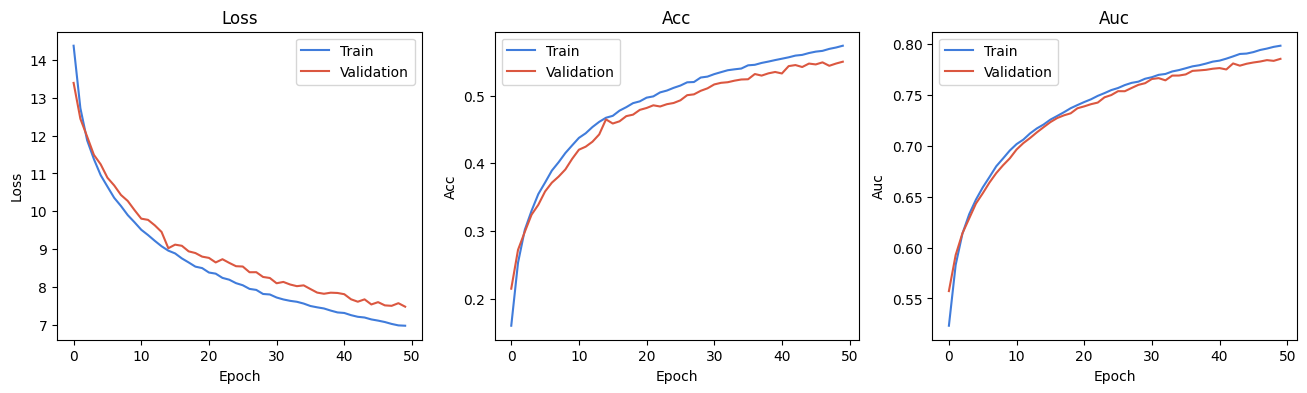

In [24]:
model = Model([2352, 800, 200, 8], [ReLU(), ReLU(), Softmax()], initialization_method="random")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)

> What are the conclusions? (1-2 paragraphs)

In order to guarantee reproducibility and to be able to understand the role of each hyperparameter in the results, a random seed was set for numpy and torch dataloader. The following table summarizes the obtained results and the hyperparameters used in the experiments. With respect to the number of epochs, it is possible to note that longer training, with more epochs, resulted in better performances, but with the loss plot analysis it is possible to see some overfit signal. When it comes to learning rate evaluation, faster learning rates (1e-3 --> 5e-3) resulted in worse performances, while slower (1e-4) learning rates had better performance.However, when the learning rate value is reduced even further (5e-4 ---> 1e-5)) the results get worse.  Comparing the training and validation metrics, it is possible to note the results were similar, but int the validation stage the metrics were smaller. When the accuracy and area under curve score are compared, in all the cases the AUC metric had higher values than the balanced accuracy score . Besides of it, it is possible to conclude that this model architecture may not be sufficient to understand the pattern recognition of the problem

| Learning Rate   | Nº Epochs|Nº Neurons 1º hidden layer|Nº Neurons 1º hidden layer|Balanced Accuracy Train| Balanced Accuracy Val| AUC Score Train |AUC Score val 
| -------- | ---------- |---------- |---------- | ---------- |---------- |---------- |---------- |
| 1e-3     | 50 |800|200 |0.4732|0.5069|0.81389|0.8217|
| 5e-3     | 50|800|200 |0.2505|0.2366 |0.6315| 0.6292|
| 5e-4  | 20 |800|200 | 0.6712| 0.6244 |0.8792| 0.8401|
| 1e-4  | 50   |800| 200 | 0.7346| 0.6566 | 0.9341| 0.8922|
| 1e-4  | 70   |800| 200 |0.7547 | 0.6742 |0.9490 |0.9078|
| 1e-4  | 100   |800| 200 |  0.7782|  0.6870|0.9621|0.9175|
| 5e-4  | 20  |800|200    | 0.5894 |0.5772|0.8863|0.8796|
| 5e-4  | 50 |800|200| 0.5894 |0.5772 |0.8863| 0.8796|



2. (2 points) Experiment other two weight & bias initialization techniques (He et al. Normalization, and the other one you implemented).

  0%|          | 0/100 [00:00<?, ?it/s]

Max Training accuracy: 0.685258397879771
Max Validation accuracy: 0.6781955782098099
Max Training AUC: 0.9464847215097911
Max Validation AUC: 0.9457389989741454


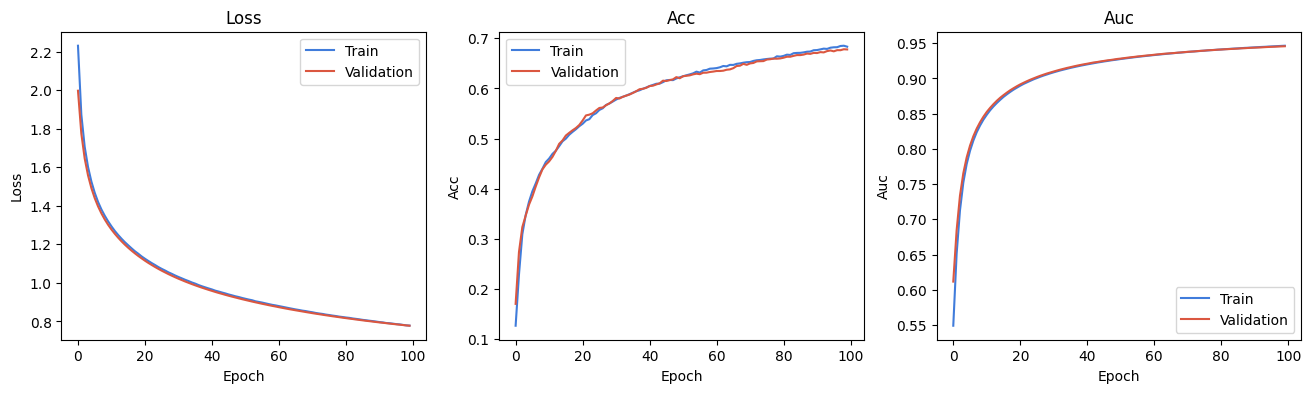

In [25]:
model_he = Model([2352, 800, 200, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model_he, lr=1e-4)
trainer = Trainer(model_he, opt, CrossEntropy())
history = trainer.train(100, train_loader, val_loader)
plot_history(history)

  0%|          | 0/100 [00:00<?, ?it/s]

Max Training accuracy: 0.46711460658228
Max Validation accuracy: 0.47262155660547467
Max Training AUC: 0.7289913695827778
Max Validation AUC: 0.7003308739914613


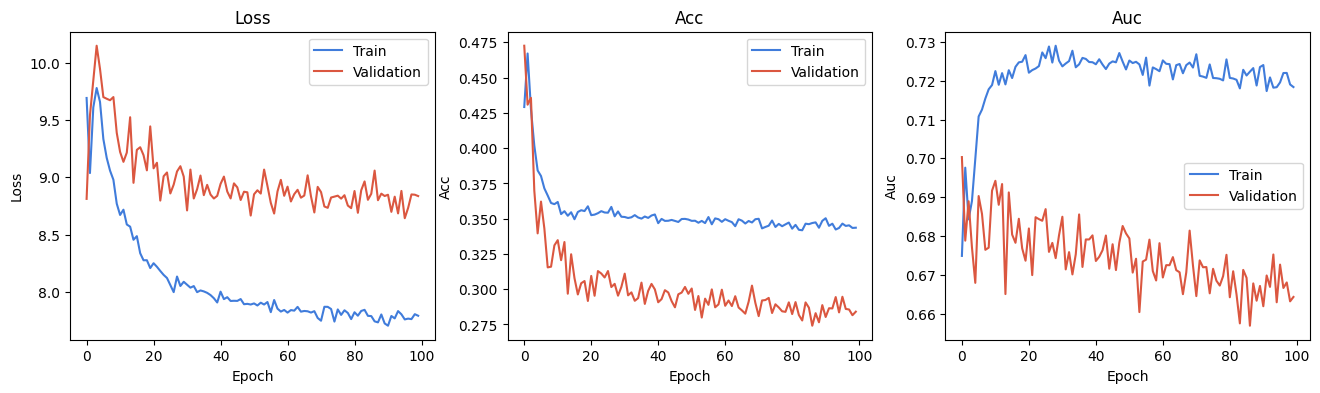

In [26]:
model_xavier = Model([2352, 800, 200, 8], [ReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model_xavier, lr=1e-4)
trainer = Trainer(model_xavier, opt, CrossEntropy())
history = trainer.train(100, train_loader, val_loader)
plot_history(history)

> What are the conclusions? How do the techniques influence the performance of the models? (1-2 paragraphs)

Comparing the initialization techniques it is noted that the 'He' initialization performed better. In the validation step, the 'He' method had the following values: Balanced Accuracy Score 67.81 % and AUC Score 94.57, while in the 'Xavier' method the  values were 47.26 % and 72.89 % for balanced accuracy and auc score respectively. In addition, by the evaluation of the Loss, Accuracy and AUC Score in the different methodologies, it is observed that the 'He' initialization had a more soft curve behavior, while the 'Xavier' method had a noiser curve behavior.   

|Inicialization| Learning Rate   | Nº Epochs|Nº Neurons 1º hidden layer|Nº Neurons 1º hidden layer|Balanced Accuracy Train| Balanced Accuracy Val| AUC Score Train |AUC Score val 
| -------- | -------- | ---------- |---------- |---------- | ---------- |---------- |---------- |---------- |
|He| 1e-4     | 50 |800|200 |0.6852|0.6781|0.9464| 0.9457|
|Xavier| 1e-4     | 50|800|200 |0.4671| 0.4726 | 0.7289|  0.7289|

3. (1 point) Choose the weight & bias initialization technique that resulted in the best performance, and try the other activation function you implemented.

  0%|          | 0/50 [00:00<?, ?it/s]

Max Training accuracy: 0.7551464948903843
Max Validation accuracy: 0.7490390768412969
Max Training AUC: 0.966279456101889
Max Validation AUC: 0.9614046607449817


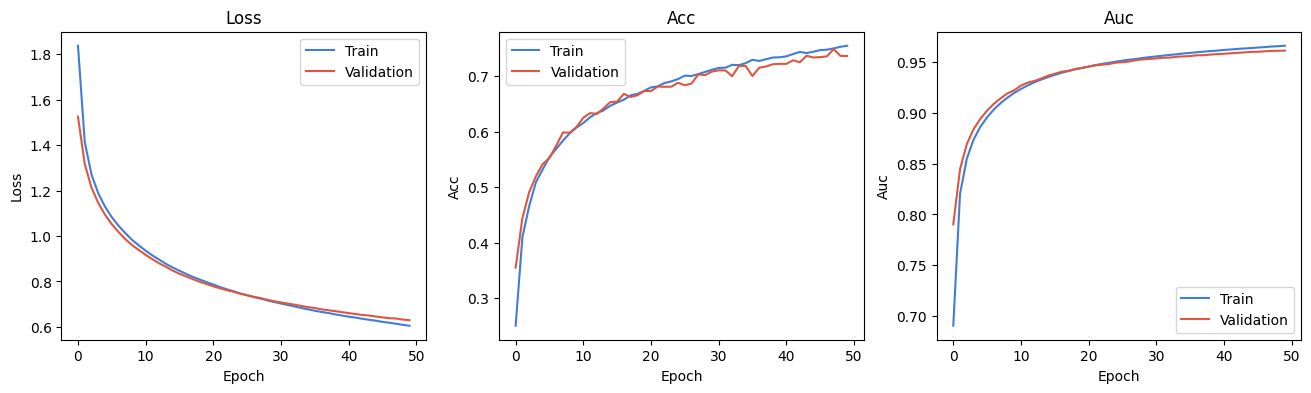

In [27]:
model_leaky_relu = Model([2352, 800, 200, 8], [LeakyRelu(), LeakyRelu(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model_leaky_relu, lr=5e-4)
trainer = Trainer(model_leaky_relu, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)

> What are the conclusions? Does it make any difference in the results? (1-2 paragraphs) 

When comparing the Leaky relu activation function with the results obtained with the Relu function it is possible to note that with the same hyperparameters, the metrics obtained of balanced accuracy and AUC Score had higher values with the Relu function.  As in the experiment with the Relu activation, the Leaky relu with 'He' initialization had smooth curve behavior. With a new activation function, it may be necessary to tune the hyperparameters again. So few experiments were performed in order to find the learning rate for LeakyRelu activation function:
With the results in the table below, it can be seen that the LeakyRelu Activation function performs better with higher learning rates. It is also observed that the LeakyRelu resulted in metrics much superior than the Relu function (table in the previous exercise)

|Inicialization| Learning Rate   | Nº Epochs|Nº Neurons 1º hidden layer|Nº Neurons 1º hidden layer|Balanced Accuracy Train| Balanced Accuracy Val| AUC Score Train |AUC Score val 
| -------- | -------- | ---------- |---------- |---------- | ---------- |---------- |---------- |---------- |
|He| 5e-3     | 50 |800|200 |0.9457|0.8449|0.9976|0.9835|
|He| 1e-3     | 50 |800|200 |0.8135|0.7783| 0.9786|0.9693|
|He| 5e-4     | 50|800|200 |0.7562|0.7365 | 0.96532|0.9590  |
|He| 1e-4     | 50 |800|200 |0.6196| 0.6129|0.9249|0.9224 |


4. (3 points) Explore different network architectures, varying the number of layers and the number of neurons in each layer. It is an empirical experiment.

  0%|          | 0/50 [00:00<?, ?it/s]

Max Training accuracy: 0.9940916791358576
Max Validation accuracy: 0.8497119165392356
Max Training AUC: 0.9999471615816053
Max Validation AUC: 0.98474292972426


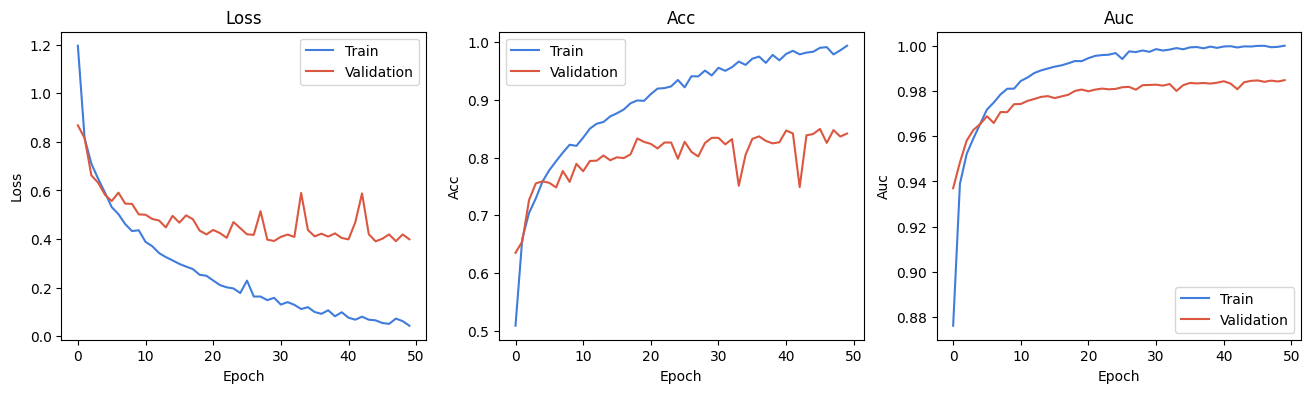

In [28]:
model_layers_neurons = Model([2352, 1600,1000,400,50,8], [LeakyRelu(),LeakyRelu(),LeakyRelu(),LeakyRelu(),Softmax()], initialization_method="he")
opt = SGDOptimizer(model_layers_neurons, lr=5e-3)
trainer = Trainer(model_layers_neurons, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)

> What are the conclusions? How does the number of layers impact the performance of the models? (2-4 paragraphs) 

With the experiments carried out, it was possible to evidence the contribution of the addition of layers and neurons in the metric's performance. 

In the first experiments it was evaluated the metrics obtained in a  single layer model. In order to check it, it was tested three configurations of number of neurons in this single layer (10, 20, and 100). with the results, it was possible to note that when the single layer had more neurons (100). With the increase in the number of neurons, the model obtained higher metrics values, increasing its value around 11.8% more than the value of the baseline (78.52 % for 10 neurons and 87.80% for 100 neurons). Then, it was evaluated the role of one more layer in the neural network architecture. It was noticed that with a architecture with two layers (100, 50 neurons) improved approximately 2% in the metrics analyzed when compared with just one layer with 100 neurons. The following step was to double the number of neurons in each layer, the result obtained demonstrates that this change in architecture was also able to improve the metrics in more 2 %. The next step was to add a new layer with 100 neurons. As result, this new layer impact in a increase of more 2% in the metrics. When a 4º layer was added, another 2% improvement was noticed. Finally, a 5º layer was added and this one impacts another 1 %.

With these experiments, it was possible to notice that the implementation of new layers and the addition of neurons have improved the baseline (neural network with just one layer and 10 neurons) which had accuracy metrics of 78.52 % and 78.38% to 99.15% and 86.71% in the training and validation step. 

Another conclusion was relevant to training time. When training with a single layer was performed, the average training time was xs, while with 5 layers the time was approximately 15 minutes

|Inicialization| Learning Rate   | Nº Epochs|Nº Neurons 1º hidden layer|Nº Neurons 2º hidden layer|Nº Neurons 3º hidden layer|Nº Neurons 4º hidden layer|Balanced Accuracy Train| Balanced Accuracy Val| AUC Score Train |AUC Score val 
| -------- | -------- | -------- | -------- | ---------- |---------- |---------- | ---------- |---------- |---------- |---------- |
|He| 5e-3     | 50 | 10 |--|-- |--|0.7852|0.7838|0.9744|0.9683 |
|He| 5e-3     | 50 | 20 |--|-- |--|0.8422|0.8160|0.9839|0.9748|
|He| 5e-3     | 50 | 100 |--|-- |--|0.8780 |0.8253|0.9900|0.9798 |
|He| 5e-3     | 50 | 100 |50|-- |--|0.8981 |0.8292|0.9932| 0.9817 |
|He| 5e-3     | 50 | 200 |100|-- |--| 0.9154|0.8439|0.9949|0.9829 |
|He| 5e-3     | 50 | 400 |200|-- |--| 0.9378|0.8515|0.9973| 0.9842|
|He| 5e-3     | 50 | 400 |200|100 |--| 0.9594|0.8503|0.9986| 0.9844|
|He| 5e-3     | 50 | 800 |200|100 |--|0.9603|0.8587|0.9986|0.9858|
|He| 5e-3     | 50 | 1600 |1000|400 |--|0.9857|0.8690|0.9997|0.9859|
|He| 5e-3     | 50 | 1600 |1000|400 |--|0.9857|0.8690|0.9997|0.9859|
|He| 5e-3     | 50 | 1600 |1000|400 |50|0.9915|0.8671|0.9999|0.9864|



5. (2 points) Pick the best network architecture and train your model using the optimizer you chose to implement.

  0%|          | 0/50 [00:00<?, ?it/s]

Max Training accuracy: 0.7371279916840476
Max Validation accuracy: 0.7827492988923325
Max Training AUC: 0.9463461243758127
Max Validation AUC: 0.9682532454364741


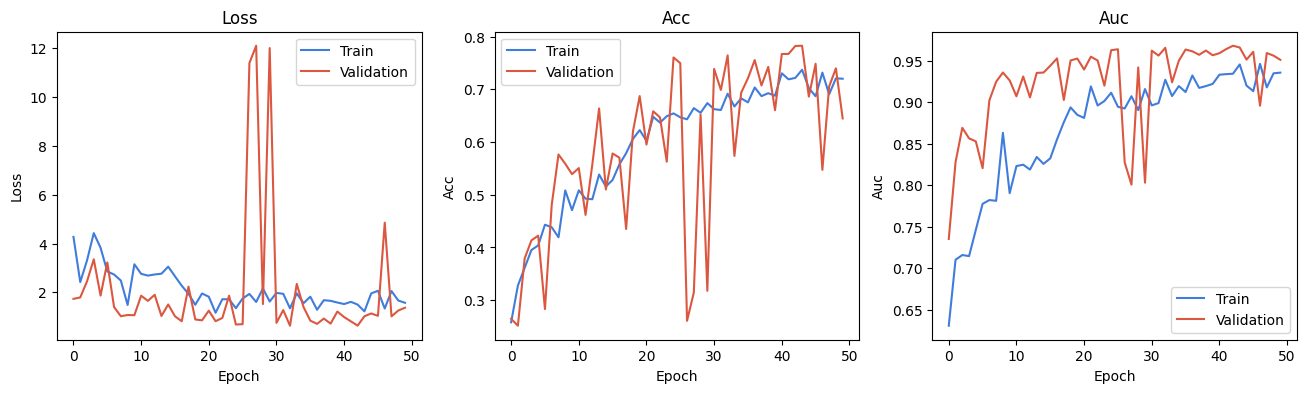

781.8591122627258


In [29]:
start = time.time()
model_optimizer = Model([2352, 1600,1000,500,50,8], [LeakyRelu(),LeakyRelu(),LeakyRelu(),LeakyRelu(),Softmax()], initialization_method="he")
opt = RMSpropOptimizer(model_optimizer, lr=5e-3)
trainer = Trainer(model_optimizer, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)
end = time.time()

print(end - start)

> What are the conclusions? Does the change of optimizer anyhow impact the loss curve over the epochs? (1-2 paragraphs) 

With the obtained result, it is possible to note that the SGDOtimizer with the best model SGD hyperparameters configuration had worse performance. 
with the change of the optimizer it is necessary to tune the hyperparameters again, finding the best configuration for the same. One possibility for this performance degradation is that the optimal learning rate for the SGD optimizer is too high for the RMSprop. In order to evaluate this hypothesis, some experiments were performed. With the obtained results, it is possible to note that RMS optimizer has better behavior with slower learning rates than the SGD optimizer

|Inicialization| Learning Rate   | Nº Epochs|Nº Neurons 1º hidden layer|Nº Neurons 2º hidden layer|Nº Neurons 3º hidden layer|Nº Neurons 4º hidden layer|Balanced Accuracy Train| Balanced Accuracy Val| AUC Score Train |AUC Score val 
| -------- | -------- | -------- | -------- | ---------- |---------- |---------- | ---------- |---------- |---------- |---------- |
|He| 5e-3     | 50 | 1600 |1000|500 |50|0.8230|0.7967|0.9718|0.9704 |
|He| 5e-4     | 50 | 1600 |1000|500 |50|0.9862|0.8554|0.9994|0.9804|
|He| 1e-4     | 50 | 1600 |1000|500 |50|0.9949|0.8654|0.9998|0.9854|



6. (1 point) Pick your **best model**, make predictions to the test set and submit them to the Kaggle competition [3rd ML Assignment](https://www.kaggle.com/t/cbf42d49ae514153bd4d04e0a69d684f). Print your score considering the public leaderboard.

  0%|          | 0/50 [00:00<?, ?it/s]

Max Training accuracy: 0.9892041751424409
Max Validation accuracy: 0.8700602745500579
Max Training AUC: 0.999826370585871
Max Validation AUC: 0.9872587998160701


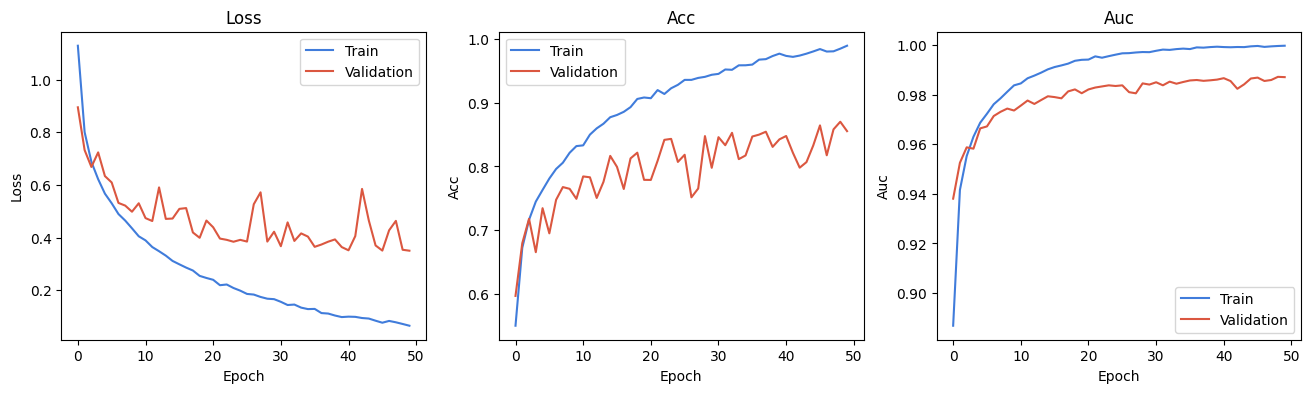

In [30]:
model_best = Model([2352,1600, 1000,400,8], [LeakyRelu(),LeakyRelu(),LeakyRelu(),Softmax()], initialization_method="he")
opt = SGDOptimizer(model_best, lr=5e-3)
trainer = Trainer(model_best, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)

In [31]:
# preds = []
# for batch in test_loader:
#     pred = model.forward(batch)
#     preds.append(pred)
# preds = np.concatenate(preds, 0).argmax(1)

In [32]:
preds = []
for batch in test_loader:
    pred = model.forward(batch)
    preds.append(pred)
preds = np.concatenate(preds, 0)

In [33]:
preds2 = []
for batch in test_loader:
    pred2 = model_best.forward(batch)
    preds2.append(pred)
preds2 = np.concatenate(preds, 0)

In [34]:
med = (preds + preds) / 2
final_pred = med.argmax(1)

In [35]:
final_pred

array([3, 6, 1, ..., 3, 1, 2])

In [36]:
final_pred

array([3, 6, 1, ..., 3, 1, 2])

In [37]:
#convert to list
y_pred_list = final_pred.tolist()

#Creating a new dataframe
df_kaggle = pd.DataFrame((final_pred), columns=['cell_type'])

In [38]:
df_kaggle

,cell_type
0,3
1,6
2,1
3,6
4,4
...,...
3416,2
3417,3
3418,3
3419,1


In [39]:
df_kaggle.to_csv('pred_ensemble.csv', index=True)

In [40]:
df = pd.read_csv('pred_ensemble.csv')

In [41]:
df

,Unnamed: 0,cell_type
0,0,3
1,1,6
2,2,1
3,3,6
4,4,4
...,...,...
3416,3416,2
3417,3417,3
3418,3418,3
3419,3419,1


In [42]:
df = df.rename(columns={'Unnamed: 0': 'index'})

In [43]:
df.to_csv('pred_ensemble.csv', index=False)

> What are the conclusions? (1-2 paragraphs)


The best model developed during the activity has the following validation metrics: Balanced Accuracy Score (86.90 %) and AUC Score (98.59 %). When this model was submitted to the leaderboard, where the AUC Score was the evaluation metric, the obtained result was 85.23 %
it is possible to notice a reduction of 15.67 % in the metric when the test set it is compared with validation set
